En este archivo vamos a entrenar una red neuronal para predecir el resultado de los partidos de la Champions bsándonos en datos de los último 7 años.

Para empezar primero cargamos las librerias necesarias.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.utils import to_categorical
from keras.layers import Dropout
from keras.optimizers import Adam
from keras import regularizers
import matplotlib.pyplot as plt
import random

Ahora vamos a empezar el entrenamiento para predecir resultados, pero antes de ello vamos a transformar las columnas string de equipos en numéricas para poder evaluarlas y analizarlas durante el procesamiento de la red neuronal.

In [2]:
# Cargar los datos del ranking UEFA
uefa_ranking = pd.read_csv("data/UEFA_Ranking.csv")

#Saca el número de valores unicos de la columna Club de ranking UEFA
uefa_ranking['Club'].nunique()

570

In [3]:
# Crear un diccionario para mapear nombres de equipos a números únicos
team_mapping = {team: idx + 1 for idx, team in enumerate(uefa_ranking['Club'])}

# Cargar los datos de los partidos de la Champions League 2017
champions_data = pd.read_csv("data/champions-league-2017.csv")

# Crear una columna Home Team Name que sea una copia de la columna Home Team
champions_data['Home Team Name'] = champions_data['Home Team']

# Crear una columna Away Team Name que sea una copia de la columna Away Team
champions_data['Away Team Name'] = champions_data['Away Team']

# Reemplazar nombres de equipos por números en las columnas correspondientes
champions_data['Home Team'] = champions_data['Home Team'].map(team_mapping)
champions_data['Away Team'] = champions_data['Away Team'].map(team_mapping)
champions_data['Winner'] = champions_data['Winner'].map(team_mapping)

Vamos a comprobar que todos los datos están bien.

In [4]:
# Ver las primeras filas de los datos
print(champions_data.head())

   Match Number Round Number  Home Team  Away Team Result  Winner  \
0             1            1         20         62  1 - 2      62   
1             2            1         11         26  3 - 0      11   
2            13            1          2         53  3 - 0       2   
3            14            1         50          8  0 - 5       8   
4            25            1          9         66  6 - 0       9   

   Home Team Goals  Away Team Goals  Match Goals     Home Team Name  \
0                1                2            3            Benfica   
1                3                0            3  Manchester United   
2                3                0            3     Bayern München   
3                0                5            5             Celtic   
4                6                0            6            Chelsea   

        Away Team Name  
0          CSKA Moscow  
1             FC Basel  
2           Anderlecht  
3  Paris Saint-Germain  
4           Qarabag FK  


In [5]:
# analizar los datos
print(champions_data.describe())

       Match Number   Home Team   Away Team      Winner  Home Team Goals  \
count    125.000000  125.000000  125.000000  125.000000       125.000000   
mean      63.000000   25.432000   25.464000   17.312000         1.784000   
std       36.228442   28.471076   28.445631   22.202302         1.532361   
min        1.000000    1.000000    1.000000    1.000000         0.000000   
25%       32.000000    6.000000    6.000000    4.000000         1.000000   
50%       63.000000   14.000000   14.000000   10.000000         1.000000   
75%       94.000000   36.000000   36.000000   23.000000         3.000000   
max      125.000000  120.000000  120.000000  120.000000         7.000000   

       Away Team Goals  Match Goals  
count       125.000000   125.000000  
mean          1.424000     3.208000  
std           1.398525     1.622901  
min           0.000000     0.000000  
25%           0.000000     2.000000  
50%           1.000000     3.000000  
75%           2.000000     4.000000  
max        

In [6]:
# ver los datos nulos
print(champions_data.isnull().sum())

Match Number       0
Round Number       0
Home Team          0
Away Team          0
Result             0
Winner             0
Home Team Goals    0
Away Team Goals    0
Match Goals        0
Home Team Name     0
Away Team Name     0
dtype: int64


Ahora vamos a comenzar el proceso de entrenamiento de la red neuronal

In [7]:
'''
# Preprocesamiento de datos
X = champions_data[['Home Team', 'Away Team', 'Home Team Goals', 'Away Team Goals']].values
y = champions_data['Winner'].values

# Separar características categóricas y numéricas
categorical_features = ['Home Team', 'Away Team']
numeric_features = ['Home Team Goals', 'Away Team Goals']

X_categorical = champions_data[categorical_features].values
X_numeric = champions_data[numeric_features].values

# Codificar características categóricas
X_categorical_encoded = np.zeros_like(X_categorical)
for i in range(X_categorical.shape[1]):
    label_encoder = LabelEncoder()
    X_categorical_encoded[:, i] = label_encoder.fit_transform(X_categorical[:, i])

# Normalizar características numéricas
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X_numeric)

# Combinar características categóricas y numéricas
X_combined = np.concatenate((X_categorical_encoded, X_numeric_scaled), axis=1)

# Codificar etiquetas
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(champions_data['Winner'])
num_classes = len(label_encoder.classes_)

# Dividir datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Normalizar los datos
X_train = X_train / np.max(X_train, axis=0)
X_test = X_test / np.max(X_test, axis=0)

# Convertir etiquetas a one-hot encoding
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

# Definir modelo de red neuronal con más complejidad
model = Sequential()
model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dense(num_classes, activation='sigmoid'))

# Compilar modelo con hiperparámetros ajustados
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entrenar modelo
model.fit(X_train, y_train, epochs=100, batch_size=40, validation_split=0.2)

# Evaluar modelo
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
'''

'\n# Preprocesamiento de datos\nX = champions_data[[\'Home Team\', \'Away Team\', \'Home Team Goals\', \'Away Team Goals\']].values\ny = champions_data[\'Winner\'].values\n\n# Separar características categóricas y numéricas\ncategorical_features = [\'Home Team\', \'Away Team\']\nnumeric_features = [\'Home Team Goals\', \'Away Team Goals\']\n\nX_categorical = champions_data[categorical_features].values\nX_numeric = champions_data[numeric_features].values\n\n# Codificar características categóricas\nX_categorical_encoded = np.zeros_like(X_categorical)\nfor i in range(X_categorical.shape[1]):\n    label_encoder = LabelEncoder()\n    X_categorical_encoded[:, i] = label_encoder.fit_transform(X_categorical[:, i])\n\n# Normalizar características numéricas\nscaler = StandardScaler()\nX_numeric_scaled = scaler.fit_transform(X_numeric)\n\n# Combinar características categóricas y numéricas\nX_combined = np.concatenate((X_categorical_encoded, X_numeric_scaled), axis=1)\n\n# Codificar etiquetas\nlab

In [8]:
# Codificar los nombres de los equipos
label_encoder = LabelEncoder()
champions_data['Home Team'] = label_encoder.fit_transform(champions_data['Home Team'])
champions_data['Away Team'] = label_encoder.transform(champions_data['Away Team'])

# Crear una columna para representar el resultado del partido
champions_data['Home is Winner'] = champions_data['Home Team Goals'] - champions_data['Away Team Goals']
champions_data['Home is Winner'] = champions_data['Home is Winner'].apply(lambda x: 1 if x > 0 else 0)  # 1 si el equipo local ganó, 0 si no

# Dividir los datos en características (X) y variable objetivo (y)
X = champions_data[['Home Team', 'Away Team']]
y = champions_data['Home is Winner']
# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
'''
# Preprocesamiento de datos
X = champions_data[['Home Team', 'Away Team']].values
y = champions_data['Winner'].values

# Codificar etiquetas
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)
y = to_categorical(y, num_classes=num_classes)
'''

# Dividir datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir modelo de red neuronal
model = Sequential()
model.add(Dense(128, input_dim=2, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compilar modelo
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.005), metrics=['accuracy'])

# Entrenar modelo
model.fit(X_train, y_train, epochs=90, batch_size=42, validation_data=(X_test, y_test))

# Evaluar modelo
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Epoch 1/90


c:\Users\javie\OneDrive\Documents\GitHub\Champions\venv\lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.5230 - loss: 1.5376 - val_accuracy: 0.6400 - val_loss: 0.9006
Epoch 2/90
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6076 - loss: 1.2324 - val_accuracy: 0.6400 - val_loss: 0.8765
Epoch 3/90
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6951 - loss: 1.1935 - val_accuracy: 0.6400 - val_loss: 0.7908
Epoch 4/90
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6713 - loss: 0.9880 - val_accuracy: 0.6000 - val_loss: 0.7866
Epoch 5/90
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6821 - loss: 0.8304 - val_accuracy: 0.6400 - val_loss: 0.7327
Epoch 6/90
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7131 - loss: 0.7282 - val_accuracy: 0.6000 - val_loss: 0.5965
Epoch 7/90
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7181 - loss: 0.6565 - val_accuracy: 0.6400 - val_loss: 0.6698
Epoch 8/90
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5846 - loss: 0.9394 - val_accuracy: 0.6000 - val_loss: 0.6423
Epoch 9/90

Vemos que el entrenamiento inicial ha ido sin problemas. Vamos a probar a ver que predicciones realizaría nuestra red neuronal en base a los partidos de la Champions utilizada para obtener una medida de precisión real. Para ello primero vamos a medir la precisión de una predicción en general.

In [9]:
# Hacer predicciones en los datos de prueba
predictions = model.predict(X_test)

# Redondear las predicciones a etiquetas binarias (0 o 1)
predicted_labels = (predictions > 0.5).astype(int)

# Calcular la precisión
accuracy = np.mean(predicted_labels.flatten() == y_test)
print("Accuracy on test data:", accuracy)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Accuracy on test data: 0.64


Como puede verse con este resultado y la medición general anterior, la precisión del modelo es casi inexistente debido al alto error, por lo que vamos a seguir entrenándolo. Primero vamos a aplicar ingeniería de características para darle al modelo más variables sobre las que extraer información. Algunas de estas nos serán útiles a la hora de predecir el resultado de cada partido:

In [10]:
# Calcular la diferencia de goles entre los equipos
champions_data['Goal Difference'] = champions_data['Home Team Goals'] - champions_data['Away Team Goals']

# Calcular la proporción de goles marcados por cada equipo en relación con el total de goles en el partido
champions_data['Home Goals Ratio'] = champions_data['Home Team Goals'] / champions_data['Match Goals']
champions_data['Away Goals Ratio'] = champions_data['Away Team Goals'] / champions_data['Match Goals']

# Fusionar los datos de champions_data con la información de uefa_ranking basado en el nombre del equipo local
champions_data = champions_data.merge(uefa_ranking[['Club', '17/18']], left_on='Home Team Name', right_on='Club', how='left')
champions_data.rename(columns={'17/18': 'Home Team Evaluation'}, inplace=True)
champions_data.drop(columns=['Club'], inplace=True)

# Fusionar los datos de champions_data con la información de uefa_ranking basado en el nombre del equipo visitante
champions_data = champions_data.merge(uefa_ranking[['Club', '17/18']], left_on='Away Team Name', right_on='Club', how='left')
champions_data.rename(columns={'17/18': 'Away Team Evaluation'}, inplace=True)
champions_data.drop(columns=['Club'], inplace=True)

# Para las columnas Result '0 - 0' se añaden 2 columnas: Penalties y Penalties Winner
champions_data['Penalties'] = champions_data['Result'].apply(lambda x: 1 if x == '0 - 0' else 0)
champions_data['Penalties Winner'] = champions_data.apply(lambda row: row['Winner'] if row['Penalties'] == 1 else None, axis=1)

#Para la columna Round Number cambiar Round of 16 - Game 1 por 7, Round of 16 - Game 2 por 8, Qtr Finals - Game 1 por 9,
# Qtr Finals - Game 2 por 10, Semi Finals - Game 1 por 11, Semi Finals - Game 2 por 12, Final por 13
round_number_mapping = {
    '1': 1,
    '2': 2,
    '3': 3,
    '4': 4,
    '5': 5,
    '6': 6,
    'Round of 16 - Game 1': 7,
    'R16 Game 1': 7,
    'Round of 16 - Game 2': 8,
    'R16 Game 2': 8,
    'Qtr Finals - Game 1': 9,
    'QF Game 1': 9,
    'Qtr Finals - Game 2': 10,
    'QF Game 2': 10,
    'Semi Finals - Game 1': 11,
    'SF Game 1': 11,
    'Semi Finals - Game 2': 12,
    'SF Game 2': 12,
    'Final': 13
}

champions_data['Round Number'] = champions_data['Round Number'].map(round_number_mapping).fillna(champions_data['Round Number'])

# Ver las primeras filas de los datos
print(champions_data.head())


   Match Number  Round Number  Home Team  Away Team Result  Winner  \
0             1             1         15         27  1 - 2      62   
1             2             1         10         19  3 - 0      11   
2            13             1          1         26  3 - 0       2   
3            14             1         25          7  0 - 5       8   
4            25             1          8         28  6 - 0       9   

   Home Team Goals  Away Team Goals  Match Goals     Home Team Name  \
0                1                2            3            Benfica   
1                3                0            3  Manchester United   
2                3                0            3     Bayern München   
3                0                5            5             Celtic   
4                6                0            6            Chelsea   

        Away Team Name  Home is Winner  Goal Difference  Home Goals Ratio  \
0          CSKA Moscow               0               -1          0.333333  

In [11]:
# Ver las estadísticas de los datos
print(champions_data.describe())

       Match Number  Round Number   Home Team   Away Team      Winner  \
count    125.000000    125.000000  125.000000  125.000000  125.000000   
mean      63.000000      4.728000   13.536000   13.568000   17.312000   
std       36.228442      2.823793    9.400192    9.360466   22.202302   
min        1.000000      1.000000    0.000000    0.000000    1.000000   
25%       32.000000      2.000000    5.000000    5.000000    4.000000   
50%       63.000000      4.000000   13.000000   13.000000   10.000000   
75%       94.000000      6.000000   21.000000   21.000000   23.000000   
max      125.000000     13.000000   31.000000   31.000000  120.000000   

       Home Team Goals  Away Team Goals  Match Goals  Home is Winner  \
count       125.000000       125.000000   125.000000       125.00000   
mean          1.784000         1.424000     3.208000         0.44800   
std           1.532361         1.398525     1.622901         0.49929   
min           0.000000         0.000000     0.000000  

In [12]:
# Ver los datos nulos
print(champions_data.isnull().sum())

Match Number              0
Round Number              0
Home Team                 0
Away Team                 0
Result                    0
Winner                    0
Home Team Goals           0
Away Team Goals           0
Match Goals               0
Home Team Name            0
Away Team Name            0
Home is Winner            0
Goal Difference           0
Home Goals Ratio          7
Away Goals Ratio          7
Home Team Evaluation      0
Away Team Evaluation      0
Penalties                 0
Penalties Winner        118
dtype: int64


In [13]:
# Ver las columnas Home Goals Ratio y Away Goals Ratio donde hay datos nulos
print(champions_data[['Home Goals Ratio', 'Away Goals Ratio']], '\n')
print(champions_data[champions_data['Home Goals Ratio'].isnull()])

     Home Goals Ratio  Away Goals Ratio
0            0.333333          0.666667
1            1.000000          0.000000
2            1.000000          0.000000
3            0.000000          1.000000
4            1.000000          0.000000
..                ...               ...
120          0.714286          0.285714
121          0.333333          0.666667
122          0.500000          0.500000
123          0.666667          0.333333
124          0.750000          0.250000

[125 rows x 2 columns] 

     Match Number  Round Number  Home Team  Away Team Result  Winner  \
5              26             1         13          6  0 - 0       7   
40             29             3         28          6  0 - 0       7   
55             44             4         23          2  0 - 0       3   
78             45             5          5          2  0 - 0       3   
102           103             7          9         10  0 - 0      11   
104           105             8          4         11  0 - 0  

Vemos aquí el problema de partidos donde no hay goles. De momento vamos a dejarlo como está para darle más realismo al entrenamiento de la red neuronal:

In [14]:
# Codificar los nombres de los equipos
label_encoder = LabelEncoder()
champions_data['Home Team'] = label_encoder.fit_transform(champions_data['Home Team'])
champions_data['Away Team'] = label_encoder.transform(champions_data['Away Team'])

'''# Preprocesamiento de datos con nuevas características
X = champions_data[['Home Team', 'Away Team', 'Home Team Evaluation', 'Away Team Evaluation', 'Home Team Goals', 'Away Team Goals', 'Home Goals Ratio', 'Away Goals Ratio', 'Penalties', 'Penalties Winner']].values
y = champions_data['Home is Winner']'''

# Preprocesamiento de datos con nuevas características
X = champions_data[['Home Team', 'Away Team', 'Home Team Evaluation', 'Away Team Evaluation']].values
y = champions_data['Home is Winner']

'''
# Separar características categóricas y numéricas
categorical_features = ['Home Team', 'Away Team']
numeric_features = ['Home Team Evaluation', 'Away Team Evaluation', 'Home Team Goals', 'Away Team Goals', 'Home Goals Ratio', 'Away Goals Ratio', 'Penalties', 'Penalties Winner']

X_categorical = champions_data[categorical_features].values
X_numeric = champions_data[numeric_features].values

# Codificar características categóricas
X_categorical_encoded = np.zeros_like(X_categorical)
for i in range(X_categorical.shape[1]):
    label_encoder = LabelEncoder()
    X_categorical_encoded[:, i] = label_encoder.fit_transform(X_categorical[:, i])

# Normalizar características numéricas
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X_numeric)

# Combinar características categóricas y numéricas
X_combined = np.concatenate((X_categorical_encoded, X_numeric_scaled), axis=1)

# Codificar etiquetas
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(champions_data['Winner'])
num_classes = len(label_encoder.classes_)
y = to_categorical(y, num_classes=num_classes)'''

print("Número de muestras en X:", X.shape[0])
print("Número de muestras en y:", y.shape[0])

# Dividir datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

# Normalizar los datos
X_train = X_train / np.max(X_train, axis=0)
X_test = X_test / np.max(X_test, axis=0)


Número de muestras en X: 125
Número de muestras en y: 125


Ahora vamos a ampliar el alcance de nuestra red neuronal:

In [15]:
# Definir modelo de red neuronal con más complejidad
model = Sequential()
model.add(Dense(256, input_shape=(X_train.shape[1],), activation='tanh', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(128, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='tanh'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compilar modelo con hiperparámetros ajustados
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Entrenar modelo
model.fit(X_train, y_train, epochs=100, batch_size=40, validation_split=0.2)

# Evaluar modelo
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Epoch 1/100


c:\Users\javie\OneDrive\Documents\GitHub\Champions\venv\lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step - accuracy: 0.5833 - loss: 0.7604 - val_accuracy: 0.6000 - val_loss: 0.7446
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5667 - loss: 0.7642 - val_accuracy: 0.6500 - val_loss: 0.7272
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5417 - loss: 0.7587 - val_accuracy: 0.7500 - val_loss: 0.7112
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6000 - loss: 0.7541 - val_accuracy: 0.8000 - val_loss: 0.6969
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5917 - loss: 0.7432 - val_accuracy: 0.8500 - val_loss: 0.6799
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6333 - loss: 0.7186 - val_accuracy: 0.9000 - val_loss: 0.6561
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.6583 - loss: 0.7114 - val_accuracy: 0.9000 - val_loss: 0.6245
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.5833 - loss: 0.7110 - val_accuracy: 0.9000 - val_loss: 0.5899
Epo

La precisión ahora está un poco mejor ya que el error es más bajo, pero vamos a ver si podemos seguir mejorando. Para ello, vamos a ir probando diferentes parámetros y configuraciones para ajustar la red neuronal:

In [16]:
# Codificar los nombres de los equipos
label_encoder = LabelEncoder()
champions_data['Home Team'] = label_encoder.fit_transform(champions_data['Home Team'])
champions_data['Away Team'] = label_encoder.transform(champions_data['Away Team'])

'''# Definir características y variable objetivo
X = champions_data[['Home Team', 'Away Team', 'Home Team Evaluation', 'Away Team Evaluation',
                    'Home Goals Ratio', 'Away Goals Ratio',
          'Penalties', 'Penalties Winner']]
y = champions_data['Home is Winner']'''

# Definir características y variable objetivo
X = champions_data[['Round Number', 'Home Team', 'Away Team', 'Home Team Evaluation', 'Away Team Evaluation']]
y = champions_data['Home is Winner']

'''

# Preprocesamiento de datos con nuevas características
X = champions_data[['Home Team', 'Away Team', 'Home Team Evaluation', 'Away Team Evaluation', 'Home Team Goals', 'Away Team Goals', 'Home Goals Ratio', 'Away Goals Ratio', 'Penalties', 'Penalties Winner']].values
y = champions_data['Winner'].values

# Separar características categóricas y numéricas
categorical_features = ['Home Team', 'Away Team']
numeric_features = ['Home Team Evaluation', 'Away Team Evaluation', 'Home Team Goals', 'Away Team Goals', 'Home Goals Ratio', 'Away Goals Ratio', 'Penalties', 'Penalties Winner']

X_categorical = champions_data[categorical_features].values
X_numeric = champions_data[numeric_features].values

# Codificar características categóricas
X_categorical_encoded = np.zeros_like(X_categorical)
for i in range(X_categorical.shape[1]):
    label_encoder = LabelEncoder()
    X_categorical_encoded[:, i] = label_encoder.fit_transform(X_categorical[:, i])

# Normalizar características numéricas
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X_numeric)

# Combinar características categóricas y numéricas
X_combined = np.concatenate((X_categorical_encoded, X_numeric_scaled), axis=1)

# Codificar etiquetas
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(champions_data['Winner'])
num_classes = len(label_encoder.classes_)
print("Número de clases:", num_classes)
y = to_categorical(y, num_classes=num_classes)

'''

# Dividir datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=31)

ajustes = []
capas = ["softmax", "relu", "sigmoid", "tanh", "linear"]
optimizador = ["SGD", "RMSprop", "Adam", "AdamW", "Adadelta",
               "Adagrad", "Adamax", "Adafactor", "Nadam", "Ftrl", "Lion"]

num_capas = [1, 2, 3, 4, 5]
num_neuronas = [16, 32, 64, 128, 256, 512, 1024]
learning_rate = [0.1, 0.01, 0.001, 0.0001]

target_accuracy = 0.7
target_loss = 0.3

for _ in range(50):
    # Configuración aleatoria
    configuracion_aleatoria = {
        "capa_activacion": random.choice(capas),
        "optimizador": random.choice(optimizador),
        "num_capas": random.choice(num_capas),
        "num_neuronas": random.choice(num_neuronas),
        "learning_rate": random.choice(learning_rate)
    }

    # Crear el modelo con la configuración aleatoria
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(
        configuracion_aleatoria["num_neuronas"], input_dim=5, activation=configuracion_aleatoria["capa_activacion"]))
    for _ in range(configuracion_aleatoria["num_capas"] - 1):
        model.add(tf.keras.layers.Dense(
            configuracion_aleatoria["num_neuronas"], activation=configuracion_aleatoria["capa_activacion"]))

    # Última capa ajustada para el problema de clasificación multiclase
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    # Compilar el modelo con el optimizador y learning rate aleatorio
    optimizer = getattr(tf.keras.optimizers, configuracion_aleatoria["optimizador"])(
        learning_rate=configuracion_aleatoria["learning_rate"])
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy', metrics=['accuracy'])

    # Entrenar el modelo
    history = model.fit(X_train, y_train, epochs=100, batch_size=64)

    # Evaluar modelo
    loss, accuracy = model.evaluate(X_test, y_test)
    print("Test Loss:", loss)
    print("Test Accuracy:", accuracy)


    # Verificar si se alcanzaron las condiciones de término
    if accuracy >= target_accuracy and 0 <= loss <= target_loss:
        break

    # Si no se alcanzaron las condiciones de término, se guarda la configuración y se ordena por precisión en orden ascendente y evitando duplicados
    ajustes.append((configuracion_aleatoria, accuracy, loss))
    print(ajustes)

    # Guardar en un archivo txt
    with open('ajustes.txt', 'w') as f:
        for item in ajustes:
            f.write("%s\n" % str(item))

Epoch 1/100


c:\Users\javie\OneDrive\Documents\GitHub\Champions\venv\lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5011 - loss: 32.8631 
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5060 - loss: 13.8185 
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7815 - loss: 5.5718 
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6941 - loss: 3.8953 
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7790 - loss: 2.3598 
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6273 - loss: 2.5490 
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6322 - loss: 1.2966 
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7557 - loss: 1.0427 
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7533 - loss: 0.8279 
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6270 - loss: 0.7042 
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6604 - loss: 0.5476 
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7766 - loss: 0.5701 

Parece que aumentar la precisión va a ser imposible a menos que añadamos nuevos datos. Vamos pues a continuar añadiéndo datos de entrenamiento. Para ello vamos a prepararlos primero:

In [ ]:
champions_data2 = pd.read_csv("data/champions-league-2018.csv")
champions_data3 = pd.read_csv("data/champions-league-2019.csv")
champions_data4 = pd.read_csv("data/champions-league-2020.csv")
champions_data5 = pd.read_csv("data/champions-league-2021.csv")
champions_data6 = pd.read_csv("data/champions-league-2022.csv")

# Reemplazar nombres de equipos por números en las columnas correspondientes
champions = [champions_data2, champions_data3, champions_data4, champions_data5, champions_data6]
years = ['18/19', '19/20', '20/21', '21/22', '22/23']
for data, year in zip(champions, years):

    # Crear una columna Home Team Name que sea una copia de la columna Home Team
    data['Home Team Name'] = data['Home Team']
    # Crear una columna Away Team Name que sea una copia de la columna Away Team
    data['Away Team Name'] = data['Away Team']
    
    data['Home Team'] = data['Home Team'].map(team_mapping)
    data['Away Team'] = data['Away Team'].map(team_mapping)
    data['Winner'] = data['Winner'].map(team_mapping)

    # Crear una columna para representar el resultado del partido
    data['Home is Winner'] = data['Home Team Goals'] - data['Away Team Goals']
    data['Home is Winner'] = data['Home is Winner'].apply(lambda x: 1 if x > 0 else 0)  # 1 si el equipo local ganó, 0 si no

    # Calcular la diferencia de goles entre los equipos
    data['Goal Difference'] = data['Home Team Goals'] - data['Away Team Goals']

    # Calcular la proporción de goles marcados por cada equipo en relación con el total de goles en el partido
    data['Home Goals Ratio'] = data['Home Team Goals'] / data['Match Goals']
    data['Away Goals Ratio'] = data['Away Team Goals'] / data['Match Goals']

    # Calcular la diferencia de goles entre los equipos
    data['Goal Difference'] = data['Home Team Goals'] - data['Away Team Goals']

    # Calcular la proporción de goles marcados por cada equipo en relación con el total de goles en el partido
    data['Home Goals Ratio'] = data['Home Team Goals'] / data['Match Goals']
    data['Away Goals Ratio'] = data['Away Team Goals'] / data['Match Goals']


In [ ]:
# Ver los datos nulos de cada conjunto de datos
for i, data in enumerate(champions):
    print(f"Data {i + 2} null values:\n{data.isnull().sum()}\n")

Data 2 null values:
Match Number        0
Round Number        0
Home Team           0
Away Team           0
Result              0
Winner              0
Home Team Goals     0
Away Team Goals     0
Match Goals         0
Home Team Name      0
Away Team Name      0
Home is Winner      0
Goal Difference     0
Home Goals Ratio    7
Away Goals Ratio    7
dtype: int64

Data 3 null values:
Match Number        0
Round Number        0
Home Team           0
Away Team           0
Result              0
Winner              0
Home Team Goals     0
Away Team Goals     0
Match Goals         0
Home Team Name      0
Away Team Name      0
Home is Winner      0
Goal Difference     0
Home Goals Ratio    4
Away Goals Ratio    4
dtype: int64

Data 4 null values:
Match Number        0
Round Number        0
Home Team           0
Away Team           0
Result              0
Winner              0
Home Team Goals     0
Away Team Goals     0
Match Goals         0
Home Team Name      0
Away Team Name      0
Home is Wi

Vemos que el csv 2 y 3 tienen datos nulos en partidos. Vamos a visualizarlos:

In [ ]:
#Ver las filas Home Team, Away Team y Winner donde hay datos nulos en champions_data2
# Seleccionar las filas donde hay valores nulos en las columnas específicas
null_data = champions_data2[champions_data2[['Home Team', 'Away Team', 'Winner']].isnull().any(axis=1)]

# Mostrar las filas seleccionadas
print(null_data[['Home Team', 'Away Team', 'Winner']])

Empty DataFrame
Columns: [Home Team, Away Team, Winner]
Index: []


Las filas de Home Team donde no se ha podido dar un número al equipo de champions_data2 son la 4, 49 y 86. De Away Team la 24, 44 y 77 y de Winner la 49 que como ya ha salido se descarta. Para solucionar esto vamos a introducir en UEFA_Ranking.csv esos equipos al final y actualizar el mapeo. Para ello buscamos en data/champions-league-2018.csv esas filas, extraemos el nombre del equipo de la columna correspondiente y lo añadimos a UEFA_Ranking con todos los campos 0 excepto el de Position que tendrá el mismo número + 1 que el de la fila anterior última. Después volvemos a mapear:

In [ ]:
#Ver la fila 4, 24, 44, 49, 77, 86 de champions-league-2018.csv
league_2018 = pd.read_csv("data/champions-league-2018.csv")
print(league_2018.iloc[[4, 24, 44, 49, 77, 86]])

    Match Number  Round Number            Home Team            Away Team  \
4              5           1.0        Crvena zvezda               Napoli   
24            25           2.0  Paris Saint-Germain        Crvena zvezda   
44            45           3.0            Liverpool        Crvena zvezda   
49            50           4.0        Crvena zvezda            Liverpool   
77            78           5.0               Napoli        Crvena zvezda   
86            87           6.0        Crvena zvezda  Paris Saint-Germain   

   Result               Winner  Home Team Goals  Away Team Goals  Match Goals  
4   0 - 0               Napoli                0                0            0  
24  6 - 1  Paris Saint-Germain                6                1            7  
44  4 - 0            Liverpool                4                0            4  
49  2 - 0        Crvena zvezda                2                0            2  
77  3 - 1               Napoli                3                1   

El problema es el equipo Crvena zvezda. Vamos a añadirlo al mapeo una única vez:

In [ ]:
# Agregar una fila para el equipo "Crvena zvezda" al archivo UEFA_Ranking.csv
new_row = {'Club': 'Crvena zvezda'}

if 'Crvena zvezda' not in uefa_ranking['Club'].values:
    uefa_ranking = pd.concat([uefa_ranking, pd.DataFrame([new_row])], ignore_index=True)

    # Guardar el DataFrame actualizado en un nuevo archivo CSV
    uefa_ranking.to_csv("data/UEFA_Ranking.csv", index=False)

In [ ]:
uefa_ranking = pd.read_csv("data/UEFA_Ranking.csv")

# Actualizar el mapeo de nombres de equipos a números únicos
team_mapping = {team: idx + 1 for idx, team in enumerate(uefa_ranking['Club'])}

champions_data2 = pd.read_csv("data/champions-league-2018.csv")
champions_data3 = pd.read_csv("data/champions-league-2019.csv")
champions_data4 = pd.read_csv("data/champions-league-2020.csv")
champions_data5 = pd.read_csv("data/champions-league-2021.csv")
champions_data6 = pd.read_csv("data/champions-league-2022.csv")

# Reemplazar nombres de equipos por números en las columnas correspondientes
champions = [champions_data2, champions_data3, champions_data4, champions_data5, champions_data6]
for data in champions:

    # Crear una columna Home Team Name que sea una copia de la columna Home Team
    data['Home Team Name'] = data['Home Team']
    # Crear una columna Away Team Name que sea una copia de la columna Away Team
    data['Away Team Name'] = data['Away Team']
    
    data['Home Team'] = data['Home Team'].map(team_mapping)
    data['Away Team'] = data['Away Team'].map(team_mapping)
    data['Winner'] = data['Winner'].map(team_mapping)

    # Crear una columna para representar el resultado del partido
    data['Home is Winner'] = data['Home Team Goals'] - data['Away Team Goals']
    data['Home is Winner'] = data['Home is Winner'].apply(lambda x: 1 if x > 0 else 0)  # 1 si el equipo local ganó, 0 si no

    # Calcular la diferencia de goles entre los equipos
    data['Goal Difference'] = data['Home Team Goals'] - data['Away Team Goals']

    # Calcular la proporción de goles marcados por cada equipo en relación con el total de goles en el partido
    data['Home Goals Ratio'] = data['Home Team Goals'] / data['Match Goals']
    data['Away Goals Ratio'] = data['Away Team Goals'] / data['Match Goals']

    # Calcular la diferencia de goles entre los equipos
    data['Goal Difference'] = data['Home Team Goals'] - data['Away Team Goals']

    # Calcular la proporción de goles marcados por cada equipo en relación con el total de goles en el partido
    data['Home Goals Ratio'] = data['Home Team Goals'] / data['Match Goals']
    data['Away Goals Ratio'] = data['Away Team Goals'] / data['Match Goals']


#Champions 2018

In [ ]:

print(champions_data2.head())

# Fusionar los datos de champions_data2 con la información de uefa_ranking basado en el nombre del equipo local
champions_data2 = champions_data2.merge(uefa_ranking[['Club', '18/19']], left_on='Home Team Name', right_on='Club', how='left')
champions_data2.rename(columns={'18/19': 'Home Team Evaluation'}, inplace=True)
champions_data2.drop(columns=['Club'], inplace=True)

# Fusionar los datos de champions_data2 con la información de uefa_ranking basado en el nombre del equipo visitante
champions_data2 = champions_data2.merge(uefa_ranking[['Club', '18/19']], left_on='Away Team Name', right_on='Club', how='left')
champions_data2.rename(columns={'18/19': 'Away Team Evaluation'}, inplace=True)
champions_data2.drop(columns=['Club'], inplace=True)

# Para las columnas Result '0 - 0' se añaden 2 columnas: Penalties y Penalties Winner
champions_data2['Penalties'] = champions_data2['Result'].apply(lambda x: 1 if x == '0 - 0' else 0)
champions_data2['Penalties Winner'] = champions_data2.apply(lambda row: row['Winner'] if row['Penalties'] == 1 else None, axis=1)

#Para la columna Round Number cambiar Round of 16 - Game 1 por 7, Round of 16 - Game 2 por 8, Qtr Finals - Game 1 por 9,
# Qtr Finals - Game 2 por 10, Semi Finals - Game 1 por 11, Semi Finals - Game 2 por 12, Final por 13

round_number_mapping = {
'1': 1,
'2': 2,
'3': 3,
'4': 4,
'5': 5,
'6': 6,
'Round of 16 - Game 1': 7,
'R16 Game 1': 7,
'Round of 16 - Game 2': 8,
'R16 Game 2': 8,
'Qtr Finals - Game 1': 9,
'QF Game 1': 9,
'Qtr Finals - Game 2': 10,
'QF Game 2': 10,
'Semi Finals - Game 1': 11,
'SF Game 1': 11,
'Semi Finals - Game 2': 12,
'SF Game 2': 12,
'Final': 13
}

champions_data2['Round Number'] = champions_data2['Round Number'].map(round_number_mapping).fillna(champions_data2['Round Number'])

#Ver las primeras filas de los datos
print(champions_data2.head())

# Pasar todos los datos a csv
champions_data2.to_csv("data/champions-league-reviewed-2018.csv", index=False)

   Match Number  Round Number  Home Team  Away Team Result  Winner  \
0             1           1.0         18         23  2 - 1      18   
1             2           1.0          3         32  4 - 0       3   
2             3           1.0         37          7  1 - 2       7   
3             4           1.0         31         13  0 - 1      13   
4             5           1.0        570         16  0 - 0      16   

   Home Team Goals  Away Team Goals  Match Goals  Home Team Name  \
0                2                1            3  Internazionale   
1                4                0            4    FC Barcelona   
2                1                2            3       AS Monaco   
3                0                1            1     Club Brugge   
4                0                0            0   Crvena zvezda   

      Away Team Name  Home is Winner  Goal Difference  Home Goals Ratio  \
0  Tottenham Hotspur               1                1          0.666667   
1      PSV Eindhoven

In [ ]:
# Ver los datos nulos
print(champions_data2.isnull().sum())

Match Number              0
Round Number              0
Home Team                 0
Away Team                 0
Result                    0
Winner                    0
Home Team Goals           0
Away Team Goals           0
Match Goals               0
Home Team Name            0
Away Team Name            0
Home is Winner            0
Goal Difference           0
Home Goals Ratio          7
Away Goals Ratio          7
Home Team Evaluation      3
Away Team Evaluation      3
Penalties                 0
Penalties Winner        118
dtype: int64


In [ ]:
# Ver las filas donde hay valores nulos en Home Team Evaluation y Away Team Evaluation
null_data = champions_data2[champions_data2[['Home Team Evaluation', 'Away Team Evaluation']].isnull().any(axis=1)]

# Mostrar las filas seleccionadas
print(null_data[['Home Team Name', 'Home Team Evaluation', 'Away Team Name', 'Away Team Evaluation']])

         Home Team Name  Home Team Evaluation       Away Team Name  \
4         Crvena zvezda                   NaN               Napoli   
24  Paris Saint-Germain                  19.0        Crvena zvezda   
44            Liverpool                  29.0        Crvena zvezda   
49        Crvena zvezda                   NaN            Liverpool   
77               Napoli                  18.0        Crvena zvezda   
86        Crvena zvezda                   NaN  Paris Saint-Germain   

    Away Team Evaluation  
4                   18.0  
24                   NaN  
44                   NaN  
49                  29.0  
77                   NaN  
86                  19.0  


In [ ]:
# Selecciona las filas con valores nulos en 'Home Team Evaluation' o 'Away Team Evaluation'
null_home_evaluations_teams = champions_data2[champions_data2['Home Team Evaluation'].isnull()]
null_away_evaluations_teams = champions_data2[champions_data2['Away Team Evaluation'].isnull()]

# Extrae los nombres de equipo de las filas seleccionadas
null_teams_home = null_home_evaluations_teams['Home Team Name']
null_teams_away = null_away_evaluations_teams['Away Team Name']

# Imprime la lista de nombres de equipo con datos nulos
print(null_teams_home)
print(null_teams_away)


4     Crvena zvezda
49    Crvena zvezda
86    Crvena zvezda
Name: Home Team Name, dtype: object
24    Crvena zvezda
44    Crvena zvezda
77    Crvena zvezda
Name: Away Team Name, dtype: object


Vemos que la fusión de puntuaciones se ha realizado correctamente, ya que los valores coinciden con los correspondientes en el csv UEFA_Ranking.

#Champions 2019

In [ ]:
print(champions_data3.head())

# Fusionar los datos de champions_data3 con la información de uefa_ranking basado en el nombre del equipo local
champions_data3 = champions_data3.merge(uefa_ranking[['Club', '19/20']], left_on='Home Team Name', right_on='Club', how='left')
champions_data3.rename(columns={'19/20': 'Home Team Evaluation'}, inplace=True)
champions_data3.drop(columns=['Club'], inplace=True)

# Fusionar los datos de champions_data3 con la información de uefa_ranking basado en el nombre del equipo visitante
champions_data3 = champions_data3.merge(uefa_ranking[['Club', '19/20']], left_on='Away Team Name', right_on='Club', how='left')
champions_data3.rename(columns={'19/20': 'Away Team Evaluation'}, inplace=True)
champions_data3.drop(columns=['Club'], inplace=True)

# Para las columnas Result '0 - 0' se añaden 2 columnas: Penalties y Penalties Winner
champions_data3['Penalties'] = champions_data3['Result'].apply(lambda x: 1 if x == '0 - 0' else 0)
champions_data3['Penalties Winner'] = champions_data3.apply(lambda row: row['Winner'] if row['Penalties'] == 1 else None, axis=1)

#Para la columna Round Number cambiar Round of 16 - Game 1 por 7, Round of 16 - Game 2 por 8, Qtr Finals - Game 1 por 9,
# Qtr Finals - Game 2 por 10, Semi Finals - Game 1 por 11, Semi Finals - Game 2 por 12, Final por 13

round_number_mapping = {
'1': 1,
'2': 2,
'3': 3,
'4': 4,
'5': 5,
'6': 6,
'Round of 16 - Game 1': 7,
'R16 Game 1': 7,
'Round of 16 - Game 2': 8,
'R16 Game 2': 8,
'Qtr Finals - Game 1': 9,
'QF Game 1': 9,
'Qtr Finals - Game 2': 10,
'QF Game 2': 10,
'Semi Finals - Game 1': 11,
'SF Game 1': 11,
'Semi Finals - Game 2': 12,
'SF Game 2': 12,
'Final': 13
}

champions_data3['Round Number'] = champions_data3['Round Number'].map(round_number_mapping).fillna(champions_data3['Round Number'])

#Ver las primeras filas de los datos
print(champions_data3.head())

# Pasar todos los datos a csv
champions_data3.to_csv("data/champions-league-reviewed-2019.csv", index=False)

   Match Number Round Number  Home Team  Away Team Result  Winner  \
0             1            1         18         44  1 - 1      44   
1             2            1         27         30  1 - 1      30   
2             3            1         16          5  2 - 0      16   
3             4            1         28         78  6 - 2      28   
4             5            1         13          3  0 - 0       3   

   Home Team Goals  Away Team Goals  Match Goals     Home Team Name  \
0                1                1            2     Internazionale   
1                1                1            2     Olympique Lyon   
2                2                0            2             Napoli   
3                6                2            8        FC Salzburg   
4                0                0            0  Borussia Dortmund   

         Away Team Name  Home is Winner  Goal Difference  Home Goals Ratio  \
0          Slavia Praha               0                0              0.50   
1 

#Champions 2020

In [ ]:
print(champions_data4.head())

# Fusionar los datos de champions_data4 con la información de uefa_ranking basado en el nombre del equipo local
champions_data4 = champions_data4.merge(uefa_ranking[['Club', '20/21']], left_on='Home Team Name', right_on='Club', how='left')
champions_data4.rename(columns={'20/21': 'Home Team Evaluation'}, inplace=True)
champions_data4.drop(columns=['Club'], inplace=True)

# Fusionar los datos de champions_data4 con la información de uefa_ranking basado en el nombre del equipo visitante
champions_data4 = champions_data4.merge(uefa_ranking[['Club', '20/21']], left_on='Away Team Name', right_on='Club', how='left')
champions_data4.rename(columns={'20/21': 'Away Team Evaluation'}, inplace=True)
champions_data4.drop(columns=['Club'], inplace=True)

# Para las columnas Result '0 - 0' se añaden 2 columnas: Penalties y Penalties Winner
champions_data4['Penalties'] = champions_data4['Result'].apply(lambda x: 1 if x == '0 - 0' else 0)
champions_data4['Penalties Winner'] = champions_data4.apply(lambda row: row['Winner'] if row['Penalties'] == 1 else None, axis=1)

#Para la columna Round Number cambiar Round of 16 - Game 1 por 7, Round of 16 - Game 2 por 8, Qtr Finals - Game 1 por 9,
# Qtr Finals - Game 2 por 10, Semi Finals - Game 1 por 11, Semi Finals - Game 2 por 12, Final por 13

round_number_mapping = {
'1': 1,
'2': 2,
'3': 3,
'4': 4,
'5': 5,
'6': 6,
'Round of 16 - Game 1': 7,
'R16 Game 1': 7,
'Round of 16 - Game 2': 8,
'R16 Game 2': 8,
'Qtr Finals - Game 1': 9,
'QF Game 1': 9,
'Qtr Finals - Game 2': 10,
'QF Game 2': 10,
'Semi Finals - Game 1': 11,
'SF Game 1': 11,
'Semi Finals - Game 2': 12,
'SF Game 2': 12,
'Final': 13
}

champions_data4['Round Number'] = champions_data4['Round Number'].map(round_number_mapping).fillna(champions_data4['Round Number'])

#Ver las primeras filas de los datos
print(champions_data4.head())

# Pasar todos los datos a csv
champions_data4.to_csv("data/champions-league-reviewed-2020.csv", index=False)

   Match Number Round Number  Home Team  Away Team Result  Winner  \
0             1            1         30         31  1 - 2      31   
1             2            1         33          6  0 - 2       6   
2             3            1         65         70  1 - 1      70   
3             4            1          9         10  0 - 0      10   
4             5            1         34         13  3 - 1      34   

   Home Team Goals  Away Team Goals  Match Goals        Home Team Name  \
0                1                2            3  Zenit St. Petersburg   
1                0                2            2           Dynamo Kyiv   
2                1                1            2         Stade Rennais   
3                0                0            0               Chelsea   
4                3                1            4                 Lazio   

      Away Team Name  Home is Winner  Goal Difference  Home Goals Ratio  \
0        Club Brugge               0               -1          0.

#Champions 2021

In [ ]:
print(champions_data5.head())

# Fusionar los datos de champions_data5 con la información de uefa_ranking basado en el nombre del equipo local
champions_data5 = champions_data5.merge(uefa_ranking[['Club', '21/22']], left_on='Home Team Name', right_on='Club', how='left')
champions_data5.rename(columns={'21/22': 'Home Team Evaluation'}, inplace=True)
champions_data5.drop(columns=['Club'], inplace=True)

# Fusionar los datos de champions_data5 con la información de uefa_ranking basado en el nombre del equipo visitante
champions_data5 = champions_data5.merge(uefa_ranking[['Club', '21/22']], left_on='Away Team Name', right_on='Club', how='left')
champions_data5.rename(columns={'21/22': 'Away Team Evaluation'}, inplace=True)
champions_data5.drop(columns=['Club'], inplace=True)

# Para las columnas Result '0 - 0' se añaden 2 columnas: Penalties y Penalties Winner
champions_data5['Penalties'] = champions_data5['Result'].apply(lambda x: 1 if x == '0 - 0' else 0)
champions_data5['Penalties Winner'] = champions_data5.apply(lambda row: row['Winner'] if row['Penalties'] == 1 else None, axis=1)

#Para la columna Round Number cambiar Round of 16 - Game 1 por 7, Round of 16 - Game 2 por 8, Qtr Finals - Game 1 por 9,
# Qtr Finals - Game 2 por 10, Semi Finals - Game 1 por 11, Semi Finals - Game 2 por 12, Final por 13

round_number_mapping = {
'1': 1,
'2': 2,
'3': 3,
'4': 4,
'5': 5,
'6': 6,
'Round of 16 - Game 1': 7,
'R16 Game 1': 7,
'Round of 16 - Game 2': 8,
'R16 Game 2': 8,
'Qtr Finals - Game 1': 9,
'QF Game 1': 9,
'Qtr Finals - Game 2': 10,
'QF Game 2': 10,
'Semi Finals - Game 1': 11,
'SF Game 1': 11,
'Semi Finals - Game 2': 12,
'SF Game 2': 12,
'Final': 13
}

champions_data5['Round Number'] = champions_data5['Round Number'].map(round_number_mapping).fillna(champions_data5['Round Number'])

#Ver las primeras filas de los datos
print(champions_data5.head())

# Pasar todos los datos a csv
champions_data5.to_csv("data/champions-league-reviewed-2021.csv", index=False)

   Match Number Round Number  Home Team  Away Team Result  Winner  \
0             2            1         55         11  2 - 1      55   
1             3            1         10         28  1 - 1      28   
2             1            1         19        504  2 - 2     504   
3             4            1         33         20  0 - 0      20   
4             5            1          3          2  0 - 3       2   

   Home Team Goals  Away Team Goals  Match Goals Home Team Name  \
0                2                1            3     Young Boys   
1                1                1            2        Sevilla   
2                2                2            4     Villarreal   
3                0                0            0    Dynamo Kyiv   
4                0                3            3   FC Barcelona   

      Away Team Name  Home is Winner  Goal Difference  Home Goals Ratio  \
0  Manchester United               1                1          0.666667   
1        FC Salzburg            

#Champions 2022

In [ ]:
print(champions_data6.head())

# Fusionar los datos de champions_data6 con la información de uefa_ranking basado en el nombre del equipo local
champions_data6 = champions_data6.merge(uefa_ranking[['Club', '22/23']], left_on='Home Team Name', right_on='Club', how='left')
champions_data6.rename(columns={'22/23': 'Home Team Evaluation'}, inplace=True)
champions_data6.drop(columns=['Club'], inplace=True)

# Fusionar los datos de champions_data6 con la información de uefa_ranking basado en el nombre del equipo visitante
champions_data6 = champions_data6.merge(uefa_ranking[['Club', '22/23']], left_on='Away Team Name', right_on='Club', how='left')
champions_data6.rename(columns={'22/23': 'Away Team Evaluation'}, inplace=True)
champions_data6.drop(columns=['Club'], inplace=True)

# Para las columnas Result '0 - 0' se añaden 2 columnas: Penalties y Penalties Winner
champions_data6['Penalties'] = champions_data6['Result'].apply(lambda x: 1 if x == '0 - 0' else 0)
champions_data6['Penalties Winner'] = champions_data6.apply(lambda row: row['Winner'] if row['Penalties'] == 1 else None, axis=1)

#Para la columna Round Number cambiar Round of 16 - Game 1 por 7, Round of 16 - Game 2 por 8, Qtr Finals - Game 1 por 9,
# Qtr Finals - Game 2 por 10, Semi Finals - Game 1 por 11, Semi Finals - Game 2 por 12, Final por 13

round_number_mapping = {
'1': 1,
'2': 2,
'3': 3,
'4': 4,
'5': 5,
'6': 6,
'Round of 16 - Game 1': 7,
'R16 Game 1': 7,
'Round of 16 - Game 2': 8,
'R16 Game 2': 8,
'Qtr Finals - Game 1': 9,
'QF Game 1': 9,
'Qtr Finals - Game 2': 10,
'QF Game 2': 10,
'Semi Finals - Game 1': 11,
'SF Game 1': 11,
'Semi Finals - Game 2': 12,
'SF Game 2': 12,
'Final': 13
}

champions_data6['Round Number'] = champions_data6['Round Number'].map(round_number_mapping).fillna(champions_data6['Round Number'])

#Ver las primeras filas de los datos
print(champions_data6.head())

# Pasar todos los datos a csv
champions_data6.to_csv("data/champions-league-reviewed-2022.csv", index=False)

   Match Number Round Number  Home Team  Away Team Result  Winner  \
0             1            1         43          9  1 - 0      43   
1             2            1         13         38  3 - 0      13   
2             3            1         28         25  1 - 1      25   
3             4            1         50          1  0 - 3       1   
4             5            1         24         21  1 - 4      21   

   Home Team Goals  Away Team Goals  Match Goals     Home Team Name  \
0                1                0            1      Dinamo Zagreb   
1                3                0            3  Borussia Dortmund   
2                1                1            2        FC Salzburg   
3                0                3            3             Celtic   
4                1                4            5         RB Leipzig   

     Away Team Name  Home is Winner  Goal Difference  Home Goals Ratio  \
0           Chelsea               1                1               1.0   
1      FC 

In [ ]:
champions = [champions_data, champions_data2, champions_data3, champions_data4, champions_data5, champions_data6]

# Ver los datos nulos de cada conjunto de datos
for i, data in enumerate(champions):
    print(f"Data {i + 1} null values:\n{data.isnull().sum()}\n")

Data 1 null values:
Match Number              0
Round Number              0
Home Team                 0
Away Team                 0
Result                    0
Winner                    0
Home Team Goals           0
Away Team Goals           0
Match Goals               0
Home Team Name            0
Away Team Name            0
Home is Winner            0
Goal Difference           0
Home Goals Ratio          7
Away Goals Ratio          7
Home Team Evaluation      0
Away Team Evaluation      0
Penalties                 0
Penalties Winner        118
dtype: int64

Data 2 null values:
Match Number              0
Round Number              0
Home Team                 0
Away Team                 0
Result                    0
Winner                    0
Home Team Goals           0
Away Team Goals           0
Match Goals               0
Home Team Name            0
Away Team Name            0
Home is Winner            0
Goal Difference           0
Home Goals Ratio          7
Away Goals Ratio      

Vemos que ya no hay valores nulos donde no debe haberlos, así que proseguimos con la unión de los datos:

In [35]:
# Concatenar todos los datos verticalmente
combined_data = pd.concat([champions_data, champions_data2, champions_data3, champions_data4, champions_data5, champions_data6], axis=0, ignore_index=True)

Vamos a analizar el resultado de la unión:

In [36]:
# Ver las filas union de los datos
print(combined_data.head())

   Match Number Round Number  Home Team  Away Team Result  Winner  \
0             1            1         15         27  1 - 2      62   
1             2            1         10         19  3 - 0      11   
2            13            1          1         26  3 - 0       2   
3            14            1         25          7  0 - 5       8   
4            25            1          8         28  6 - 0       9   

   Home Team Goals  Away Team Goals  Match Goals     Home Team Name  \
0                1                2            3            Benfica   
1                3                0            3  Manchester United   
2                3                0            3     Bayern München   
3                0                5            5             Celtic   
4                6                0            6            Chelsea   

        Away Team Name  Home is Winner  Goal Difference  Home Goals Ratio  \
0          CSKA Moscow               0               -1          0.333333   
1   

In [37]:
# Ver la forma de los datos combinados
print(combined_data.shape)

(744, 19)


In [38]:
# Ver los datos
print(combined_data.describe())

       Match Number   Home Team   Away Team      Winner  Home Team Goals  \
count    744.000000  744.000000  744.000000  744.000000       744.000000   
mean      62.538978   34.951613   34.229839   25.051075         1.649194   
std       35.883295   81.068207   79.237447   65.773277         1.433797   
min        1.000000    0.000000    0.000000    1.000000         0.000000   
25%       31.750000    7.000000    7.000000    5.000000         1.000000   
50%       62.500000   17.000000   17.000000   11.000000         1.000000   
75%       93.250000   30.000000   30.000000   23.000000         2.000000   
max      125.000000  570.000000  570.000000  570.000000         7.000000   

       Away Team Goals  Match Goals  Home is Winner  Goal Difference  \
count       744.000000   744.000000      744.000000       744.000000   
mean          1.403226     3.052419        0.446237         0.245968   
std           1.385870     1.723465        0.497435         2.232149   
min           0.000000     

In [39]:
# Ver los datos nulos
print(combined_data.isnull().sum())

Match Number              0
Round Number              0
Home Team                 0
Away Team                 0
Result                    0
Winner                    0
Home Team Goals           0
Away Team Goals           0
Match Goals               0
Home Team Name            0
Away Team Name            0
Home is Winner            0
Goal Difference           0
Home Goals Ratio         40
Away Goals Ratio         40
Home Team Evaluation     94
Away Team Evaluation     93
Penalties                 0
Penalties Winner        704
dtype: int64


In [40]:
#mostrar las filas con datos nulos
print(combined_data[combined_data.isnull().any(axis=1)])

     Match Number Round Number  Home Team  Away Team Result  Winner  \
0               1            1         15         27  1 - 2      62   
1               2            1         10         19  3 - 0      11   
2              13            1          1         26  3 - 0       2   
3              14            1         25          7  0 - 5       8   
4              25            1          8         28  6 - 0       9   
..            ...          ...        ...        ...    ...     ...   
739           121           11          1          4  1 - 1       4   
740           122           11         25         18  0 - 2      18   
741           123           12         18         25  1 - 0      18   
742           124           12          4          1  4 - 0       4   
743           125           13          4         18  1 - 0       4   

     Home Team Goals  Away Team Goals  Match Goals     Home Team Name  \
0                  1                2            3            Benfica   
1

In [41]:
# Sacar el numero de datos totales de las columnas ['Home Team', 'Away Team', 'Home Team Goals', 'Away Team Goals', 'Goal Difference', 'Home Goals Ratio', 'Away Goals Ratio', 'Winner']
print(combined_data[['Home Team', 'Away Team', 'Home Team Goals', 'Away Team Goals', 'Goal Difference', 'Home Goals Ratio', 'Away Goals Ratio', 'Winner']].count())

Home Team           744
Away Team           744
Home Team Goals     744
Away Team Goals     744
Goal Difference     744
Home Goals Ratio    704
Away Goals Ratio    704
Winner              744
dtype: int64


In [42]:
# Sacar el numero de datos únicos de las columnas ['Home Team', 'Away Team', 'Home Team Goals', 'Away Team Goals', 'Goal Difference', 'Home Goals Ratio', 'Away Goals Ratio', 'Winner']
print(combined_data[['Home Team', 'Away Team', 'Home Team Goals', 'Away Team Goals', 'Goal Difference', 'Home Goals Ratio', 'Away Goals Ratio', 'Winner']].nunique())

Home Team           68
Away Team           68
Home Team Goals      8
Away Team Goals      9
Goal Difference     15
Home Goals Ratio    23
Away Goals Ratio    23
Winner              65
dtype: int64


In [ ]:
# Codificar los nombres de los equipos
label_encoder = LabelEncoder()
champions_data['Home Team'] = label_encoder.fit_transform(champions_data['Home Team'])
champions_data['Away Team'] = label_encoder.transform(champions_data['Away Team'])

'''# Definir características y variable objetivo
X = champions_data[['Home Team', 'Away Team', 'Home Team Evaluation', 'Away Team Evaluation',
                    'Home Goals Ratio', 'Away Goals Ratio',
          'Penalties', 'Penalties Winner']]
y = champions_data['Home is Winner']'''

# Definir características y variable objetivo
X = champions_data[['Round Number', 'Home Team', 'Away Team', 'Home Team Evaluation', 'Away Team Evaluation'
                    ]]
y = champions_data['Home is Winner']

# Dividir datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=31)

ajustes = []
capas = ["softmax", "relu", "sigmoid", "tanh", "linear"]
optimizador = ["SGD", "RMSprop", "Adam", "AdamW", "Adadelta",
               "Adagrad", "Adamax", "Adafactor", "Nadam", "Ftrl", "Lion"]

num_capas = [1, 2, 3, 4, 5]
num_neuronas = [16, 32, 64, 128, 256, 512, 1024]
learning_rate = [0.1, 0.01, 0.001, 0.0001]

target_accuracy = 0.7
target_loss = 0.3

for _ in range(50):
    # Configuración aleatoria
    configuracion_aleatoria = {
        "capa_activacion": random.choice(capas),
        "optimizador": random.choice(optimizador),
        "num_capas": random.choice(num_capas),
        "num_neuronas": random.choice(num_neuronas),
        "learning_rate": random.choice(learning_rate)
    }

    # Crear el modelo con la configuración aleatoria
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(
        configuracion_aleatoria["num_neuronas"], input_dim=5, activation=configuracion_aleatoria["capa_activacion"]))
    for _ in range(configuracion_aleatoria["num_capas"] - 1):
        model.add(tf.keras.layers.Dense(
            configuracion_aleatoria["num_neuronas"], activation=configuracion_aleatoria["capa_activacion"]))

    # Última capa ajustada para el problema de clasificación multiclase
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    # Compilar el modelo con el optimizador y learning rate aleatorio
    optimizer = getattr(tf.keras.optimizers, configuracion_aleatoria["optimizador"])(
        learning_rate=configuracion_aleatoria["learning_rate"])
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy', metrics=['accuracy'])

    # Entrenar el modelo
    history = model.fit(X_train, y_train, epochs=100, batch_size=64)

    # Evaluar modelo
    loss, accuracy = model.evaluate(X_test, y_test)
    print("Test Loss:", loss)
    print("Test Accuracy:", accuracy)


    # Verificar si se alcanzaron las condiciones de término
    if accuracy >= target_accuracy and 0 <= loss <= target_loss:
        break

    # Si no se alcanzaron las condiciones de término, se guarda la configuración y se ordena por precisión en orden ascendente y evitando duplicados
    ajustes.append((configuracion_aleatoria, accuracy, loss))
    print(ajustes)

    # Guardar en un archivo txt
    with open('ajustes_ampliado.txt', 'w') as f:
        for item in ajustes:
            f.write("%s\n" % str(item))

'''({'capa_activacion': 'tanh', 'optimizador': 'Lion', 'num_capas': 2, 'num_neuronas': 32, 'learning_rate': 0.0001}, 0.8421052694320679, 0.4830092191696167)'''

Epoch 1/100


c:\Users\javie\OneDrive\Documents\GitHub\Champions\venv\lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5553 - loss: 0.7578  
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6117 - loss: 0.7250 
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6298 - loss: 0.6609 
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7095 - loss: 0.6152 
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7996 - loss: 0.5153 
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7018 - loss: 0.5484 
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6941 - loss: 0.6823 
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7352 - loss: 0.5572 
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7223 - loss: 0.5826 
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7557 - loss: 0.5710 
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6709 - loss: 0.5294 
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7610 - loss: 0.5245 


"({'capa_activacion': 'tanh', 'optimizador': 'Lion', 'num_capas': 2, 'num_neuronas': 32, 'learning_rate': 0.0001}, 0.8421052694320679, 0.4830092191696167)"

Vamos a ver una representación gráfica de la precisión y pérdida incurrida en el último ciclo exitoso:

In [ ]:
'''# Codificar los nombres de los equipos
label_encoder = LabelEncoder()
champions_data['Home Team'] = label_encoder.fit_transform(champions_data['Home Team'])
champions_data['Away Team'] = label_encoder.transform(champions_data['Away Team'])

# Definir características y variable objetivo
X = champions_data[['Home Team', 'Away Team', 'Home Team Evaluation', 'Away Team Evaluation', 'Home Team Win Streak', 'Away Team Win Streak']]
y = champions_data['Home is Winner']

# Dividir datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=31)

# Crear el modelo con la configuración proporcionada
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(32, input_dim=6, activation='tanh'))
model.add(tf.keras.layers.Dropout(0.8))
model.add(tf.keras.layers.Dense(
    32, activation='tanh'))

# Última capa ajustada para el problema de clasificación binaria
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))


# Compilar el modelo con el optimizador 'Lion' y learning rate proporcionados
optimizer = tf.keras.optimizers.Lion(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=150, batch_size=64, validation_data=(X_test, y_test))

# Evaluar modelo
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)'''

KeyError: "['Home Team Win Streak', 'Away Team Win Streak'] not in index"

KeyError: 'val_loss'

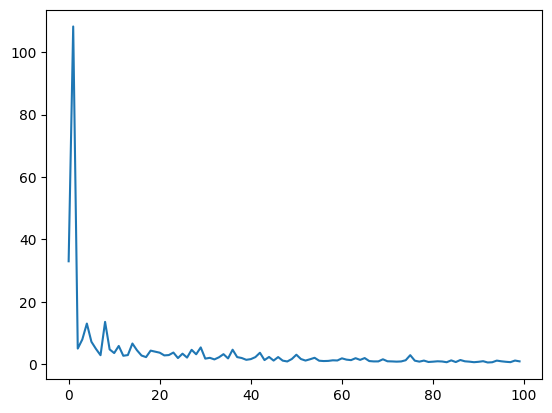

In [ ]:
# Pérdida y precisión
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

# Pérdida y precisión en la misma gráfica
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Loss and Accuracy')
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train Loss', 'Validation Loss', 'Train Accuracy', 'Validation Accuracy'], loc='upper right')
plt.show()


Ya habiendo ampliado la información disponible para entrenar la red neuronal vamos a hacer una prueba de predicción real:

<h1>PRUEBA GOLES<h1>

In [ ]:
'''# Preprocesamiento de datos
X = combined_data[['Home Team', 'Away Team', 'Goal Difference', 'Home Goals Ratio', 'Away Goals Ratio']].values
y = combined_data[['Winner', 'Home Team Goals', 'Away Team Goals']].values

# Separar características categóricas y numéricas
categorical_features = ['Home Team', 'Away Team']
numeric_features = ['Goal Difference', 'Home Goals Ratio', 'Away Goals Ratio']

X_categorical = combined_data[categorical_features].values
X_numeric = combined_data[numeric_features].values

# Codificar características categóricas
X_categorical_encoded = np.zeros_like(X_categorical)
for i in range(X_categorical.shape[1]):
    label_encoder = LabelEncoder()
    X_categorical_encoded[:, i] = label_encoder.fit_transform(X_categorical[:, i])

# Normalizar características numéricas
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X_numeric)

# Combinar características categóricas y numéricas
X_combined = np.concatenate((X_categorical_encoded, X_numeric_scaled), axis=1)

# Codificar etiquetas
label_encoder = LabelEncoder()
y_winner = label_encoder.fit_transform(y[:, 0])
y_home_goals = y[:, 1]
y_away_goals = y[:, 2]

num_winner_classes = len(label_encoder.classes_)

# Convertir etiquetas a formato categórico solo para el resultado del ganador
y_winner = to_categorical(y_winner, num_classes=num_winner_classes)

print("Número de muestras en X:", X.shape[0])
print("Número de muestras en y_winner:", y_winner.shape[0])

# Dividir datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_winner_train, y_winner_test, y_home_goals_train, y_home_goals_test, y_away_goals_train, y_away_goals_test = train_test_split(X_combined, y_winner, y_home_goals, y_away_goals, test_size=0.2, random_state=42)

# Normalizar los datos
X_train = X_train / np.max(X_train, axis=0)
X_test = X_test / np.max(X_test, axis=0)

# Definir modelo de red neuronal con arquitectura modificada
model = Sequential()
model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))

# Modelo de salida para la predicción del ganador
model.add(Dense(num_winner_classes, activation='softmax', name='winner_output'))

# Compilar y entrenar el modelo...
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_winner_train, epochs=100, batch_size=40, validation_split=0.2)

# Evaluar modelo para predicción del ganador
loss, accuracy = model.evaluate(X_test, y_winner_test)
print("Test Loss (Winner):", loss)
print("Test Accuracy (Winner):", accuracy)

# Preparar el modelo para la predicción de los goles de los equipos
model_goals = Sequential()
model_goals.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
model_goals.add(Dropout(0.5))
model_goals.add(Dense(64, activation='relu'))
model_goals.add(Dropout(0.5))
model_goals.add(Dense(32, activation='relu'))

# Modelo de salida para la predicción de los goles del equipo local
model_goals.add(Dense(1, name='home_goals_output'))

# Compilar y entrenar el modelo...
model_goals.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
model_goals.fit(X_train, y_home_goals_train, epochs=100, batch_size=40, validation_split=0.2)

# Evaluar modelo para predicción de los goles del equipo local
loss, mae = model_goals.evaluate(X_test, y_home_goals_test)
print("Test Loss (Home Goals):", loss)
print("Test MAE (Home Goals):", mae)

# Modelo de salida para la predicción de los goles del equipo visitante
model_goals.add(Dense(1, name='away_goals_output'))

# Compilar y entrenar el modelo...
model_goals.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
model_goals.fit(X_train, y_away_goals_train, epochs=100, batch_size=40, validation_split=0.2)

# Evaluar modelo para predicción de los goles del equipo visitante
loss, mae = model_goals.evaluate(X_test, y_away_goals_test)
print("Test Loss (Away Goals):", loss)
print("Test MAE (Away Goals):", mae)
'''

Número de muestras en X: 744
Número de muestras en y_winner: 744


c:\Users\javie\OneDrive\Documents\GitHub\Champions\venv\lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.0482 - loss: 4.1730 - val_accuracy: 0.0672 - val_loss: 4.1676
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0531 - loss: 4.1656 - val_accuracy: 0.0672 - val_loss: 4.1602
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0661 - loss: 4.1581 - val_accuracy: 0.0672 - val_loss: 4.1529
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0782 - loss: 4.1505 - val_accuracy: 0.0672 - val_loss: 4.1455
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0454 - loss: 4.1427 - val_accuracy: 0.0840 - val_loss: 4.1384
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0766 - loss: 4.1361 - val_accuracy: 0.0840 - val_loss: 4.1313
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0571 - loss: 4.1288 - val_accuracy: 0.0840 - val_loss: 4.1244
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0727 - loss: 4.1193 - val_accuracy: 0.0840 - 

Hemos rellenado la red neuronal con mucha más información. Ahora vamos a ver que tal predice el resultado de los partidos basándonos en la información ya existente de los csv: